# 聚类(Clustering)
使用文心百中语义模型获取embedding之后可以直接用于聚类，本notebook主要使用k-means来演示如何使用其进行聚类，其中数据来源为文心一言生成，详情请见[data_generation](../10-Data-Generation.ipynb)。

## 1. K-means 聚类

In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from typing import List
import random

embedding = np.load('../data/review_embedding.npy')
original_review = pd.read_csv('../data/reviews.csv')
n_clusters = original_review.type.unique().shape[0]
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(embedding)
original_review['Cluster'] = kmeans.labels_

/opt/anaconda3/envs/ernie/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
counts = [0 for _ in range(n_clusters)]
for cluster in original_review['Cluster']:
    counts[cluster] += 1
print(counts)

[20, 20, 20, 20]


因为我们预先知道整体为4类评论，您也可以使用肘部图来判断推荐的聚类数目，可以看到embedding的表征效果用于聚类十分好。

## 2. 聚类结果可视化

Text(0.5, 1.0, 'Clusters visualized in 2d using t-SNE')

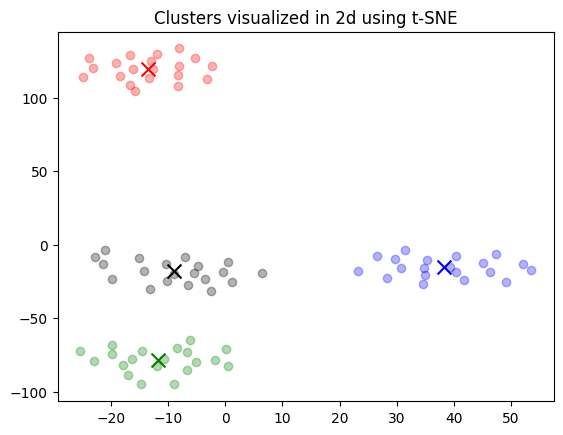

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embedding)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["black", "green", "red", "blue"]):
    xs = np.array(x)[original_review.Cluster == category]
    ys = np.array(y)[original_review.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters visualized in 2d using t-SNE")


为了可视化聚类效果，我们使用TSNE降维投影到2d维度，可以发现置信度以及容错率都非常高。

## 3. 聚类命名
在实际文本聚类过程中，我们没有提前获取label，因此可以使用文心大模型来帮助聚类命名以及特征提取。

In [56]:
import erniebot,time
from tqdm import tqdm
from collections import defaultdict

CLUSTER_TEMPLATE = "请你根据总结以下文本的特征，为这些文本设置一个主题，主题尽量精简和专业。\n文本：\n{TEXTS}"

erniebot.api_type = 'aistudio'
erniebot.access_token = '<EB_ACCESS_TOKEN>'

def handle_texts(texts:pd.DataFrame) -> str:
    res = ''

    #防止超出模型上限
    if texts.shape[0] >= 10:
        texts = texts.sample(10)
    
    for review in texts.reviews:
        res += review + '\n'
    return res

theme = defaultdict(list)

for cluster in tqdm(original_review.Cluster.unique()):
    query = CLUSTER_TEMPLATE.format(TEXTS = handle_texts(original_review[original_review.Cluster == cluster]))
    response = erniebot.ChatCompletion.create(
        model='ernie-bot-4', 
        messages=[{'role': 'user', 'content': query}]
    )
    time.sleep(1.5) # 防止频繁访问
    theme[cluster].append(response.get_result())    


100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


In [58]:
for i in theme:
    print('-'*50)
    v = theme[i]
    print(f"Theme{i}:{theme[i]}")
    print(original_review[original_review.Cluster == i].reviews.to_list())

--------------------------------------------------
Theme2:['上述文本表达的主题是“百度文心一言的评价和体验”。']
['百度文心一言真的很智能，它能准确理解我的问题并给出合适的回答。', '我使用百度文心一言的感受是，它的自然语言处理能力非常强大。', '百度文心一言帮助我解决了许多问题，我对它的表现非常满意。', '我觉得百度文心一言的搜索结果非常精确，对我有很大的帮助。', '百度文心一言的产品界面非常友好，使用起来非常方便。', '我很高兴能使用百度文心一言，它对我的工作有很大的帮助。', '我发现百度文心一言的回答越来越准确，它的学习能力非常强。', '百度文心一言的智能推荐功能非常好用，给我节省了很多时间。', '我觉得百度文心一言的客服团队非常专业，他们总能及时解决我的问题。', '百度文心一言的产品更新非常快，我能看到它在不断进步。', '我对百度文心一言的总体评价是非常好，它是一个非常优秀的AI产品。', '百度文心一言的帮助文档非常详细，对我使用产品有很大的帮助。', '我发现百度文心一言在不同的场景下都能表现得很好，非常智能。', '百度文心一言的语音识别能力非常强，我可以轻松与它进行语音交互。', '我觉得百度文心一言的价格非常合理，性价比非常高。', '百度文心一言的兼容性非常好，我可以在不同的设备上使用它。', '百度文心一言的使用体验非常流畅，我没有遇到任何卡顿的问题。', '我非常欣赏百度文心一言的创新能力，它总能给我带来惊喜。', '我认为百度文心一言是一个非常出色的AI产品，我会向我的朋友推荐它。', '百度文心一言对我的生活和工作产生了很大的影响，我非常感谢它。']
--------------------------------------------------
Theme0:['上述文本表达的主题是“百度地图的使用体验”。']
['百度地图真的很方便，路线规划很准确。', '我喜欢百度地图的实时交通信息，帮助我避开拥堵。', '百度地图的搜索功能很强大，总能找到我想要的位置。', '地图的导航语音提示很清晰，让我开车更安心。', '百度地图的周边搜索功能很好用，能快速找到附近的美食、加油站等。', '我觉得百度地图的界面设计很简洁，操作起来很顺畅。', '有时候地图